# Double-Scrolls and The Butterfly: 
## Looking at Chaotic Motion of the Lorenz Attractor and Chua's Circuit.

### By Manuel Rodriguez

# Introduction

The study of nonlinear systems encompasses a vast amount of information regarding the behavior of dynamic systems. Whether it be frameworks that describe fluid convection in weather models or the chaotic oscillations in electronic circuits, the field aims to develop models that capture the complexity of nature. We attempt to touch on the subject with a simple model. Our initial example will be the Lorenz system, a model derived from simplified atmospheric convection equations that demonstrate the emergence of chaos in deterministic systems. The resulting structure, known as the Lorenz attractor, is well recognized for its butterfly-like shape and its association with the butterfly effect. Similarly, in electrical systems, Chua's circuit stands as the first physical realization of chaos, producing the double-scroll attractor through the inclusion of a nonlinear element known as the Chua diode. In this report, I plan to use computational models to show the chaotic motion of both the Lorenz attractor and Chua's circuit, showing that both systems:

- Display sensitivity to initial conditions (Key giveaway to chaotic behavior)
- Display fractal dimensionality

And in the process of doing so we'll earn the caveat of observing the impressive shapes the trajectories of both systems display. 
  
Though both systems have their unique applications in physics, they are similar in how they can be observed and computed. 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.spatial import cKDTree
from mpl_toolkits.mplot3d import Axes3D

# Methodology

## Initial constants and the Lorenz function

Let's start with a simple merging of projects 5.5 and 5.6 in Chapter 5. This program allows us to view the shape of the Lorenz model in multiple ways, and easily tweak variables to show the chaotic effect displayed by the model. The function below defines the Lorenz system of equations and stores each derivative in a list. Here, σ is the Prandtl number, it influences how quickly heat will spread in our system compared to velocity changes. Rayleigh number ρ determines the strength of convection in the system. Finally, β is a geometric factor.

The constants below were chosen because Lorenz discovered that for these parameters the system shows an attractor type of behavior, with sensitive dependence on the initial conditions, along with the trajectories' "butterfly" spiral instead of settling to a fixed point. We'll use these constants to explore this exact phenomena. 


In [4]:
sigma = 10.0      # Prandtl number
rho = 28.0        # Rayleigh number
beta = 8.0 / 3.0  # Geometric factor

def lorenz(t, state):
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return [dx, dy, dz]


The stored Lorenz system of equations are as follows,

$$
1.) \, \frac{dx}{dt} = \sigma (y - x)
$$

This equation describes how the rate of convection changes over time, with the temperature difference (y - x) driving the flow

$$
2.) \, \frac{dy}{dt} = x (\rho - z) - y
$$

This equation describes how the horizontal temperature difference evolves over time. 

$$
3.) \, \frac{dz}{dt} = xy - \beta z
$$

This equation describes how the vertical temperature difference evolves over time.
Setting these derivatives equal to zero and solving the equations for $x,y,z$ will yield the three fixed points. The first is the origin at
$$
4.) (x,y,z) = (0,0,0)
$$
It represents an unstable equilibrium where no motion occurs, a saddle point. The second two fixed points are represented by
$$
5.) (x,y,z) = (±\sqrt{\beta(\rho - 1)} , ±\sqrt{\beta(\rho-1)} , \rho-1
$$
and are non-trivial fixed points that act as attractors at certain values of $\rho$.

## Poincaré Sections and Maps

Poincaré sections and maps are tools used in dynamical systems and chaos theory to analyze the behavior of trajectories in phase space, they're tools that simplify the study of high-dimensional systems and showcase important insights about periodicity and chaotic motion. 

Poincaré sections are 2D "slices" through the phase space of a dynamical system obtained by recording the points where a trajectory intersects a specific plane in phase space. The collection of all the points on the selected plane make up the Poincaré section, and a set of the sections across multiple selected planes make up a Poincaré map.

Below is the function to create the data for a Poincaré section for a selected "Plane Z" and store the data in a numpy array to plot later on. 


In [5]:
def poincare_section(trajectory, plane_z=20.0):

    poincare_points = []
    for i in range(1, len(trajectory)):
        z1, z2 = trajectory[i-1, 2], trajectory[i, 2] # Extract z values at consecutive points
        if (z1 < plane_z <= z2) or (z2 < plane_z <= z1): # Check if trajectory crosses the plane
            x1, y1, z1 = trajectory[i-1] #Previous
            x2, y2, z2 = trajectory[i] #Current point
            t = (plane_z - z1) / (z2 - z1) # Linear interpolation factor
            x_cross = x1 + t * (x2 - x1)  # Interpolate x-coordinate at crossing
            y_cross = y1 + t * (y2 - y1)  #Same as above, for y-coordinate
            poincare_points.append([x_cross, y_cross]) # Add crossing point to the list
    return np.array(poincare_points)


## Correlation Dimensions

Correlation Dimensions measure how the number of point pairs $N(r)$ within distance $r$ grow as $r$ decreases. 

$$ 4.) N(r) \sim r^{d_c} $$

Where $d_c$ is the correlation dimension and $N(r)$ is the number of pair of points within distance $r$.

In chaotic systems, the trajectory forms a strange attractor with fractal geometry, the correlation dimension tells us how complex the attractor is. 

Below is the function to compute the correlation dimension using cKDTree from the scipy.spatial module, which helped by providing nearest-neighbor searches and reduced the computing load on the hardware used.

In [6]:
def correlation_dimension(trajectory, radii):
    
    tree = cKDTree(trajectory)  # Build a KD-tree for efficient pairwise search
    counts = []  # Initialize list to store counts
    for r in radii:  # Loop over radii
        count = len(tree.query_pairs(r, output_type='ndarray'))  # Count pairs within radius r
        counts.append(count)  # Append count to list
    return radii, counts  # Return radii and corresponding counts



The slope of the linear region of the log-log plot that will be created in the main code is the correlation dimension. For clarity, its given by

$$d_c = \frac{\Delta \log N(r)}{\Delta \log r}$$

## Solving the Lorenz system. 

We create a function that utilizes the solve_ivp function in scipy.integrate to numerically solve the Lorenz system using the Runge-Katta 4(5) method. This will simulate the system's evolution in time and also return a trajectory in phase space. 


In [8]:
# Solve Lorenz system
def solve_lorenz(y0, t_max, h):

    t_eval = np.arange(0, t_max, h) # Create array of time points to evaluate the solution
    solution = solve_ivp(lorenz, [0, t_max], y0, t_eval=t_eval, method='RK45') # Solve the system
    return solution.t, solution.y.T   # Return time and trajectory array


## Running the Script (Main)
The following code serves as the main code for the Lorenz script. We define the paramaters for the simulation, the initial conditions for x,y,z, the total simulation time, and the time step for integration. Those initial conditions are used for the solve_lorenz function to get us a time and trajectory for our correlation_dimension and poincare_section functions. Finally, three plots are generated. One to visualize the beautiful shape of the Lorenz attractor, one to visualize a single Poincare section, and one to visualize the log-log plot of the correlation dimension. 

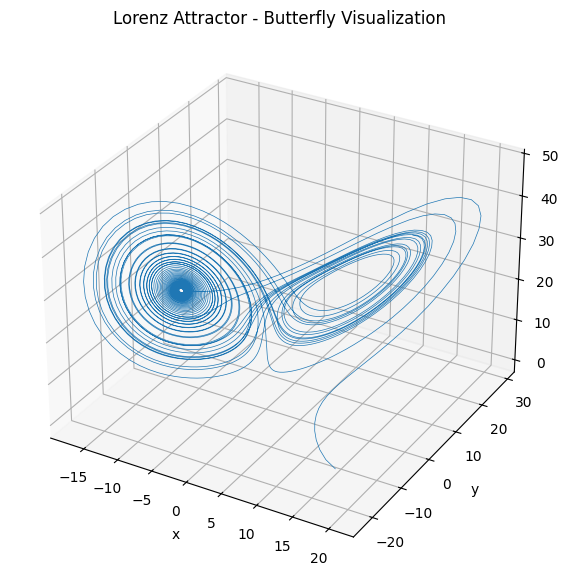

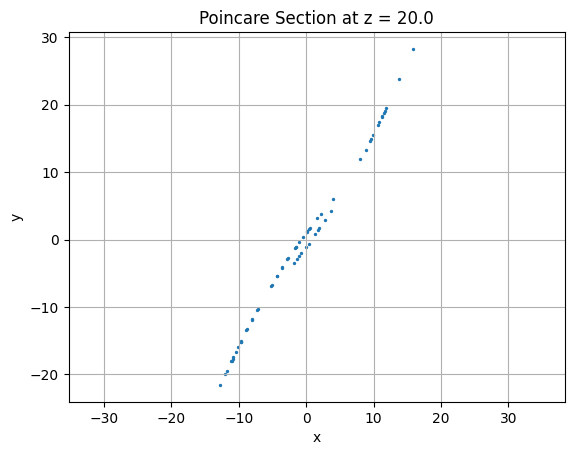

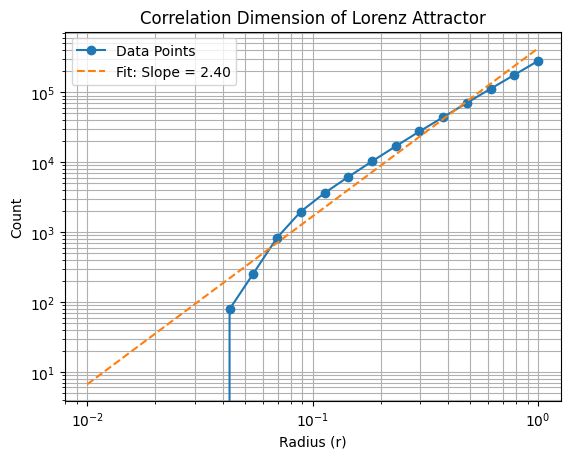

In [9]:
# Parameters for simulation
y0 = [17, -17.0, 3.0]   # Initial conditions, you can adjust these to observe the chaotic effect
t_max = 50.0          # Total simulation time
h = 0.01              # Time step

# Solve Lorenz system
time, trajectory = solve_lorenz(y0, t_max, h)

# Plot Lorenz attractor
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], lw=0.5)
ax.set_title("Lorenz Attractor - Butterfly Visualization")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

# Compute and plot Poincare section
plane_z = 20.0  # z-plane for Poincare section
poincare_points = poincare_section(trajectory, plane_z)
plt.figure()
plt.scatter(poincare_points[:, 0], poincare_points[:, 1], s=2)
plt.title(f"Poincare Section at z = {plane_z}")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.grid(True)
plt.show()

# Compute and plot correlation dimension
radii = np.logspace(-2, 0, 20)  # Radii range for correlation dimension analysis
radii, counts = correlation_dimension(trajectory, radii)

# Filter out zero counts to avoid log issues
valid_indices = np.where(np.array(counts) > 0)
radii = np.array(radii)[valid_indices]
counts = np.array(counts)[valid_indices]

# Compute the slope of the log-log plot
log_radii = np.log(radii)
log_counts = np.log(counts)
slope, intercept = np.polyfit(log_radii, log_counts, 1)

# Compute and plot correlation dimension
radii = np.logspace(-2, 0, 20)  # Radii range for correlation dimension analysis
radii, counts = correlation_dimension(trajectory, radii)
plt.figure()
plt.loglog(radii, counts, '-o', label="Data Points")
plt.loglog(radii, np.exp(intercept) * radii**slope, '--', label=f"Fit: Slope = {slope:.2f}")
plt.title("Correlation Dimension of Lorenz Attractor")
plt.xlabel("Radius (r)")
plt.ylabel("Count")
plt.grid(True, which="both")
plt.legend()
plt.show()




We can now see the famed 'butterfly' shaped trajectory of the Lorenz system in a 3D phase space. We can also see the chaotic behavior shown by the attractor, with the trajectory orbiting the fixed points. Having tweaked the initial conditions we also see how sensitive the system is. Though it retains the butterfly shape thanks to the constants far above, the path the trajectory takes drastically changes with a change in initial x, y, or z. 

The Poincaré section at z = 20.0 shows us a slice of the 3D phase space along with the points where the trajectory crosses through the plane. Changing the initial conditions will drastically alter the locations of the points, showcasing once more the chaotic behavior of the system. However, the linearity of the section might suggest some structure among the system's chaotic nature. 

The final plot, the log-log plot of the Correlation Dimension of the Lorenz Attractor. The expected value is 2.05, and though the slope seems to be heavily influenced by earlier points we can see that the slope is in fact very close to 2.05. I believe some computation error may have affected the early points, skewing the line. 

## Fractals
The significance of displaying the correlation dimension is that it shows us proof of the figure's fractal structure by displaying a value between 2 and 3. That value correlates to the model's shape "residing" in that in-between, non-integer dimension. This occurs with the folding and stretching of the trajectory in phase space.  Fractals are structures that reveal similar structures at finer resolutions. Out in the world we can observe various fractal patterns such as those found in sea shells or the arrangement of sunflower seeds as they rest in the flower. We can recognize this phenomena in the pattern the trajectory takes when "orbiting" the attractor of the model. 



## Taking it an Electrifying step further

The Lorenz system has given us an example of how simple, deterministic equations can produce complex and chaotic behavior. Through numerical simulations, we observed the butterfly shape of the Lorenz attractor, it's chaotic disposition to be affected by minor tweaks in initial conditions, and it's fractal nature showing how its geometry lies between two and three dimensions. 

While the Lorenz system originates from fluid dynamics and meteorology, it highlights universal features of nonlinear systems—features that appear across physics, engineering, and other fields.

One such system is Chua's circuit. A nonlinear electronic circuit that produces chaotic behavior similar to the Lorenz attractor. In fact, Chua’s circuit provides a physical realization of chaos through relatively simple hardware components.




# Chua's Circuit

This electric circuit is comprised of a Voltage Source $V_1$, Resistors $R_1$ and $R_2$, an Inductor $L$, Capacitors $C_1$ and $C_2$, and finally Chua's Diode, a nonlinear resistor. 

Voltage $V_1$ provides the energy to drive the circuit.

Resistor $R_1$ is usually connected to Capacitor $C_1$, controlling current flow and contributing to the damping of oscillations. 

Resistor $R_2$ is paired with the nonlinear resistor, Chua's Diode, and capacitor $C_2$.
Chua's Diode exhibits a voltage-current relationship with negative differential resistance. This destabilizes the system and induces chaotic behavior. 

The Inductor $L$ stores energy in the magnetic field when current flows through it. In our chaotic system, inductive reactance is introduced by the inductor, contributing to the circuit's inertia and phase relationships, adding to the chaotic oscillations. 

Below are the differential equations that govern the circuit. 
$$
\frac{dV_1}{dt} = \frac{1}{C_1} \left( V_2 - V_1 - g(V_1) \right)
$$

$$
\frac{dV_2}{dt} = \frac{1}{C_2} \left( V_1 - V_2 + I_L \right)
$$

$$
\frac{dI_L}{dt} = -\frac{1}{L} V_2
$$

Where:

- $V_1$: Voltage across capacitor $C_1$
- $ V_2 $: Voltage across capacitor $C_2$
- $I_L$: Current through the inductor $L$
- $g(V_1)$: The nonlinear characteristic of the Chua diode.

The nonlinear resistor $g(V_1)$ is defined as:

$$
g(V_1) = G_b V_1 + \frac{1}{2} (G_a - G_b) \left( |V_1 + B_p| - |V_1 - B_p| \right)
$$

Where:

- $G_a$: Slope of the inner region.
- $G_b$: Slope of the outer region.
- $B_p$: Breakpoint voltage of the nonlinear resistor.


Now that the very brief overview of the circuit is over with, let's continue on to observing its chaotic nature in terms of sensitivity to initial conditions, its lovely shape in  3D space, and its fractal disposition. Let's begin below. 

In [10]:
import numpy as np  
import matplotlib.pyplot as plt  
from scipy.integrate import solve_ivp  
from scipy.spatial import cKDTree  
from mpl_toolkits.mplot3d import Axes3D  

# Typical parameters when considering Chua's Circuit
alpha = 10.0  # Nonlinear parameter controlling feedback strength
beta = 14.0    # Linear feedback parameter
m0 = -8/7      # Negative slope of Chua's diode 
m1 = -5/7      # Positive slope of Chua's diode 


Overall the setup with this script is similar to the one made for the Lorenz Model, down to the functions called. Let's continue and define the function that will introduce piecewise nonlinearity to the system.

In [14]:
def chua_diode(x):
    
    if x > 1:  # If x exceeds 1, apply slope m1 and shift
        return m1 * x + (m0 - m1)
    elif x < -1:  # If x is less than -1, apply slope m1 and shift
        return m1 * x - (m0 - m1)
    else:  # For -1 <= x <= 1, apply slope m0
        return m0 * x

Next we define the ODEs that make up the system of equations for the circuit, and like before we save them in a list.

In [15]:
def chua_circuit(t, y):
    
    x, y, z = y  # Unpack the state vector into variables x, y, z
    dx = alpha * (y - x - chua_diode(x))  # Derivative of x with Chua's diode
    dy = x - y + z  # Derivative of y (linear feedback dynamics)
    dz = -beta * y  # Derivative of z (linear damping term)
    return [dx, dy, dz]  # Return the system derivatives

Then we move on to defining our poincare_section function. 

In [16]:
def poincare_section(trajectory, plane_z=5.0):
    poincare_points = []
    for i in range(1, len(trajectory)):
        z1, z2 = trajectory[i-1, 2], trajectory[i, 2]
        if (z1 < plane_z <= z2) or (z2 < plane_z <= z1):
            x1, y1, z1 = trajectory[i-1]
            x2, y2, z2 = trajectory[i]
            t = (plane_z - z1) / (z2 - z1)
            x_cross = x1 + t * (x2 - x1)
            y_cross = y1 + t * (y2 - y1)
            poincare_points.append([x_cross, y_cross])
    return np.array(poincare_points)

We can skip creating a solver function this time around, it will all be done in one line anyways so we'll just add it to the main code. Speaking of, let's move on. 

In [17]:
# Time parameters
t_start = 0  # Start time for the simulation
t_end = 100.0  # End time for the simulation
t_step = 0.1  # Step size for time discretization
t_eval = np.arange(t_start, t_end, t_step)  # Time points for evaluation

# Initial conditions
y0 = [0.2, 0.2, 0.4]  # In format [x, y, z]. Modify these to your heart's content... up to about 0.5 each. 

# Solve Chua's circuit with Runge-Katta 4(5) using solve-ivp
solution = solve_ivp(chua_circuit, [t_start, t_end], y0, t_eval=t_eval, method='RK45')

# Extract results
t = solution.t  # Extract time values
x = solution.y[0]  # Extract x-component of the solution
y = solution.y[1]  # Extract y-component of the solution
z = solution.y[2]  # Extract z-component of the solution
trajectory = np.vstack((x, y, z)).T #Forms a matrix, .T(ranspose) turns rows into columns, in this case a trajectory matrix.

In [ ]:
And now we plot. 

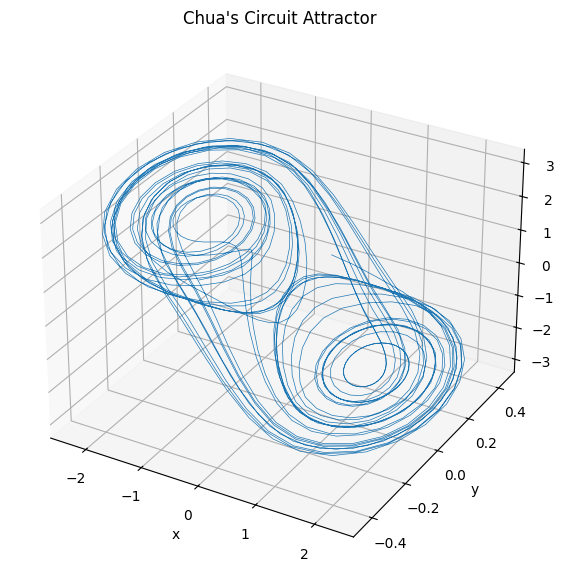

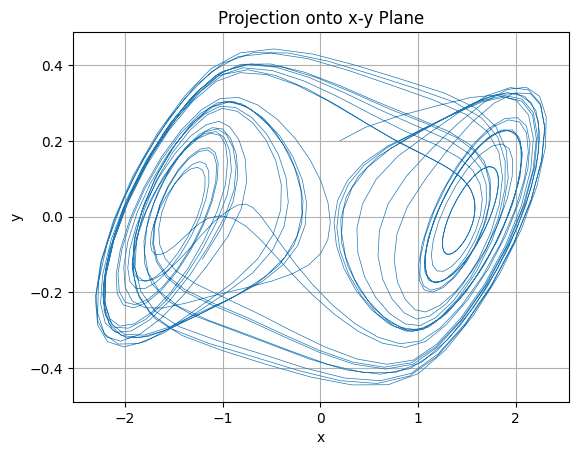

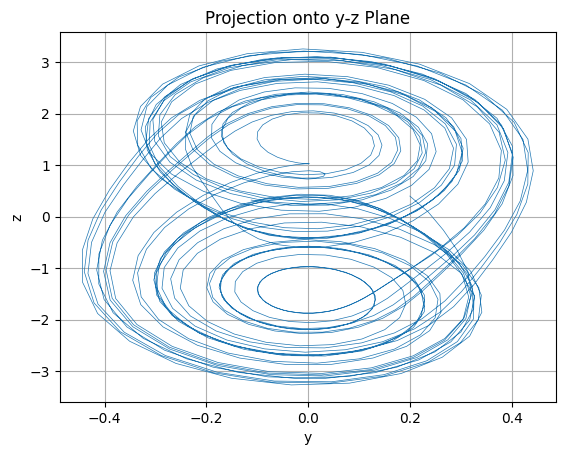

In [18]:
# Plot Chua's attractor in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, lw=0.5)
ax.set_title("Chua's Circuit Attractor")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

# 2D Projections
plt.figure()  # Create a new figure
plt.plot(x, y, lw=0.5)  # Plot projection onto x-y plane
plt.title("Projection onto x-y Plane")  # Add title
plt.xlabel("x")  # Label x-axis
plt.ylabel("y")  # Label y-axis
plt.grid(True)  # Add grid lines
plt.show()  # Display the plot

plt.figure()  # Create another new figure
plt.plot(y, z, lw=0.5)  # Plot projection onto y-z plane
plt.title("Projection onto y-z Plane")  # Add title
plt.xlabel("y")  # Label y-axis
plt.ylabel("z")  # Label z-axis
plt.grid(True)  # Add grid lines
plt.show()  # Display the plot

I introduce you to the Double-Scroll of Chua's Circuit. We'll come back to discussing this but for now let's finish plotting. 

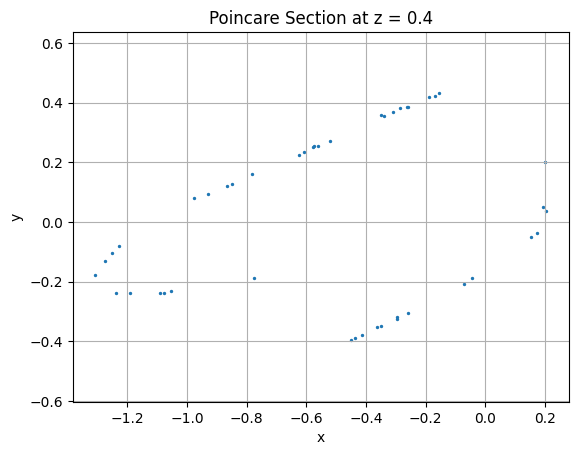

In [21]:
# Compute and plot Poincare section
plane_z = 0.4 # z-plane for Poincare section, can be modified in relativity to the dimensions of plots above
poincare_points = poincare_section(trajectory, plane_z)
plt.figure()
plt.scatter(poincare_points[:, 0], poincare_points[:, 1], s=2)
plt.title(f"Poincare Section at z = {plane_z}")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.axis('equal')
plt.show()

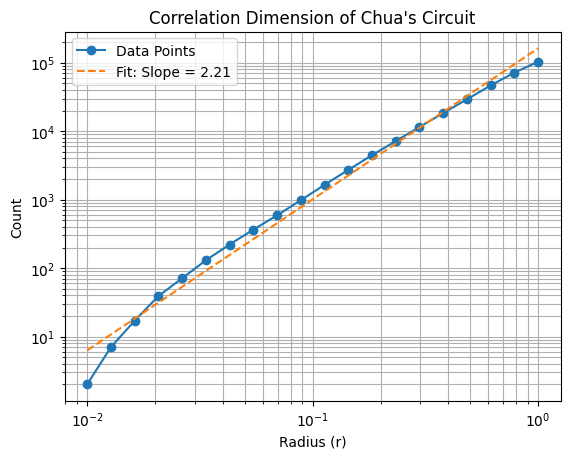

Estimated Correlation Dimension: 2.21


In [22]:

# Compute and plot correlation dimension
radii = np.logspace(-2, 0, 20)  # Radii range for correlation dimension analysis
radii, counts = correlation_dimension(trajectory, radii)

# Filter out zero counts to avoid log(0) issues
valid_indices = np.where(np.array(counts) > 0)
radii = np.array(radii)[valid_indices]
counts = np.array(counts)[valid_indices]

# Compute the slope of the log-log plot
log_radii = np.log(radii)
log_counts = np.log(counts)
slope, intercept = np.polyfit(log_radii, log_counts, 1)

# Plot the correlation dimension graph
plt.figure()
plt.loglog(radii, counts, '-o', label="Data Points")
plt.loglog(radii, np.exp(intercept) * radii**slope, '--', label=f"Fit: Slope = {slope:.2f}")
plt.title("Correlation Dimension of Chua's Circuit")
plt.xlabel("Radius (r)")
plt.ylabel("Count")
plt.grid(True, which="both")
plt.legend()
plt.show()

# Print the correlation dimension
print(f"Estimated Correlation Dimension: {slope:.2f}")


Correlation Dimension is in line with the expected value between 2 and 2.3, the partial dimensionality of the system shows it is indeed fractal in nature. Like with the Lorenz's Butterfly, the Chua Double-Scroll inhabits a space between 2D and 3D. 

# Conclusion

Chaos appears in systems that have no randomness in the governing equations, yet are highly sensitive to initial conditions. In this project we have observed two similar yet vastly different systems. Both the Lorenz model and Chua's circuit have both displayed chaotic behavior, and both have a similar fractal structure with the correlation dimension of both systems residing between 2 and 3. Despite their similarities, we can't forget that these are different systems. The Lorenz model is used in meteorology and its equations are simplified forms of those for thermal convection in the atmosphere. Chua's circuit is, well, an electrical circuit that simply contains resistors, capacitors, inductors, a nonlinear resistor, and a power source of course. These two systems come from different houses of physics, and with how similar the method is to visualize the chaos they display, I am led to believe that we could observe various other systems, of varying shapes, just the same.